<div>
    <img style="float:right;" src="images/smi-logo.png"/>
    <div style="float:left;color:#58288C;"><h1>Datenanalyse und Datenmanagement</h1></div>
</div>

---
# Notebook III: Data Exploration
In diesem Notebook geht es um die Verwendung von Python zur Erkundung eines eingelesenen Datenbestands.  
Hierzu werden einfache statistische Techniken und Visualisierungsformen eingesetzt.

## Inhaltsverzeichnis

[1. Daten einlesen und aufbereiten](#kapitel1)  
[2. Merkmale untersuchen und visualisieren](#kapitel2)  
[3. Zusammenhänge untersuchen und visualisieren](#kapitel3)  
[4. Anwendungsbeispiel Minecraft Kernbohrung](#kapitel4)  
[5. Anwendungsbeispiel Kreditvergabe](#kapitel5)  

---

## 1. Daten einlesen und aufbereiten <a id="kapitel1"/>

### 1.1. DataFrames und grobe Datenvalidierung
Pandas sind das zentrale Werkzeug zum einlesen und manipulieren von Daten in Python. Für unsere Zwecke ist die Datenstruktur des ```DataFrames``` am wichtigsten:

> **DataFrame** is a 2-dimensional labeled data structure with columns of potentially different types.  
> You can think of it like a spreadsheet or SQL table [...]. It is generally the most commonly used pandas object.  
> [(Quelle)](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html)

Dataframes haben demnach Zeilen ("Rows") und Spalten ("Columns") können zudem einen Index haben - ein datensatzidentifizierendes Merkmal, ähnlich dem Primärschlüssel in der Datenbank.  
<img src="images/dataframe.png"/>  
DataFrames organisieren die Daten im Arbeitsspeicher, die mit SQL oder über APIs aus Datenquellen eingelesen werden. Die Dokumentation zu DataFrames findest du [hier](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html). 

Nutzen wir die Daten der COVID19-API aus der letzten Übung als Beispiel: 

In [1]:
# Notebook extensions und Python Packages laden
%load_ext sql

import pandas as pd
import requests
import matplotlib.pyplot as plt

# Jupyter-Feature: Wir wollen das Diagramm direkt im Notebook sehen, nicht als Datei speichern o.ä.
%matplotlib inline

In [2]:
# API abfragen
response = requests.get("https://corona-api.com/timeline")
df = pd.json_normalize(response.json(), record_path="data")   # Im DataFrame df liegen nun die API-Daten

Nun sind die abgefragten Daten im DataFrame ```df```. Wir überprüfen zunächst oberflächlich die Fehlerfreiheit:

In [3]:
df.head(5)   # die ersten fünf Zeilen anzeigen

,updated_at,date,deaths,confirmed,recovered,active,new_confirmed,new_recovered,new_deaths,is_in_progress
0,2020-09-28T12:01:06.770Z,2020-09-28,1002226,33218093,24324011,7891856,528329,1740498,10193,True
1,2020-09-26T02:23:45.000Z,2020-09-26,992033,32689764,22583513,9114218,273530,243830,5213,NaN
2,2020-09-25T02:23:42.000Z,2020-09-25,986820,32416234,22339683,9089731,334519,227134,5944,NaN
3,2020-09-24T02:23:21.000Z,2020-09-24,980876,32081715,22112549,8988290,360194,260437,6680,NaN
4,2020-09-23T02:23:38.000Z,2020-09-23,974196,31721521,21852630,8894695,261377,265055,5506,NaN


In [4]:
df.tail(5)   # die letzten fünf Zeilen anzeigen

,updated_at,date,deaths,confirmed,recovered,active,new_confirmed,new_recovered,new_deaths,is_in_progress
246,2020-01-26T15:00:00.000Z,2020-01-25,98,3556,91,3367,680,13,14,NaN
247,2020-01-25T16:00:00.000Z,2020-01-24,68,2379,75,2236,497,3,16,NaN
248,2020-01-24T16:00:00.000Z,2020-01-23,44,1594,66,1484,288,6,8,NaN
249,2020-01-23T16:00:00.000Z,2020-01-22,35,1208,58,1115,99,2,1,NaN
250,2020-01-22T16:00:00.000Z,2020-01-21,17,555,28,510,555,28,17,NaN


In [5]:
df.sample(5) # Zufällige fünf Zeilen anzeigen

,updated_at,date,deaths,confirmed,recovered,active,new_confirmed,new_recovered,new_deaths,is_in_progress
131,2020-05-19T00:32:19.000Z,2020-05-19,323233,4895198,1837125,2734840,95719,52030,5021,NaN
50,2020-08-08T02:34:54.000Z,2020-08-08,726361,19612629,11924961,6961307,259264,200684,5455,NaN
162,2020-04-18T20:40:18.000Z,2020-04-18,159476,2316012,591508,1565028,77513,23967,5687,NaN
83,2020-07-06T17:33:59.000Z,2020-07-06,537945,11611210,6299228,4774037,170170,123588,3782,NaN
245,2020-01-27T22:59:00.000Z,2020-01-26,138,5044,113,4793,808,9,26,NaN


In [6]:
df.count()   # Anzahl der Werte je Spalte prüfen - gibt es Lücken?

updated_at        251
date              251
deaths            251
confirmed         251
recovered         251
active            251
new_confirmed     251
new_recovered     251
new_deaths        251
is_in_progress      1
dtype: int64

### 1.2. Spalten organisieren und Datentypen festlegen

> Wichtig: Bei allen Bearbeitungen des DataFrames wird eine Kopie mit den Änderungen erzeugt. Das ursprüngliche DataFrame bleibt unverändert.  
> Soll eine Änderung vorgenommen werden, kann der Ursprungsvariablen das geänderte DataFrame direkt zugeordnet werden.  
> _Beispiel: df = df.some_function()_

In [7]:
# Bekommen wir aus der API auch unnötige Zeilen/Spalten, verwerfen wir diese zunächst
# (bei Datenbanken würden wir nur die benötigten Felder mit SQL abfragen)

# Zunächst entfernen wir den unvollständigen Datensatz, der mit "is_in_progress" gekennzeichnet ist

df = df[df.is_in_progress != 1]

# Die Funktion "drop" kann sowohl Zeilen als auch Spalten entfernen.
# Für Spalten ist eine Liste der Spaltennamen anzugeben, sowie der Verweis, dass es sich um Spalten handelt (axis="columns")

df = df.drop(["updated_at", "recovered", "new_recovered", "is_in_progress"], axis="columns")

# Dazu ist es oft praktisch, Spalten einheitlich oder kürzer zu benennen

df = df.rename(columns = {
    "new_confirmed": "new_cases", 
    "confirmed":"cases"
})

df.head(2)

,date,deaths,cases,active,new_cases,new_deaths
1,2020-09-26,992033,32689764,9114218,273530,5213
2,2020-09-25,986820,32416234,9089731,334519,5944


In [8]:
df

,date,deaths,cases,active,new_cases,new_deaths
1,2020-09-26,992033,32689764,9114218,273530,5213
2,2020-09-25,986820,32416234,9089731,334519,5944
3,2020-09-24,980876,32081715,8988290,360194,6680
4,2020-09-23,974196,31721521,8894695,261377,5506
5,2020-09-22,968690,31460144,8903879,270373,5865
...,...,...,...,...,...,...
246,2020-01-25,98,3556,3367,680,14
247,2020-01-24,68,2379,2236,497,16
248,2020-01-23,44,1594,1484,288,8
249,2020-01-22,35,1208,1115,99,1


In [9]:
# Damit Datums- und Zeitangaben etwa bei der Sortierung korrekt behandelt werden können, ist im DataFrame 
# der Datentyp korrekt zu setzen.

df.date = df.date.astype("datetime64")   # astype versucht den Inhalt des Strings als Datum zu interpretieren

In [10]:
# Das Datum ist bislang eine reguläre Spalte, ein vom DataFrame separat geführter Index zählt die Zeilen von 0-n durch.
# Da es sich hier um Meldezeitpunkte handelt, ist das Datum der Index. Damit wird bspw. der Index automatisch als X-Achse in späteren Grafiken verwendet.

df = df.set_index("date")
df.head(2)

,deaths,cases,active,new_cases,new_deaths
date,,,,,
2020-09-26,992033,32689764,9114218,273530,5213
2020-09-25,986820,32416234,9089731,334519,5944


### 1.3. Daten sortieren und filtern

In [11]:
# Sortieren
df = df.sort_values("date", axis="rows", ascending=True)

In [12]:
df.head(5)

,deaths,cases,active,new_cases,new_deaths
date,,,,,
2020-01-21,17,555,510,555,17
2020-01-22,35,1208,1115,99,1
2020-01-23,44,1594,1484,288,8
2020-01-24,68,2379,2236,497,16
2020-01-25,98,3556,3367,680,14


#### Spaltenzugriff und Felder
Der Zugriff auf eine Spalte ist mit ```df["feldname"]``` möglich, wenn der Name keine Leer- oder Sonderzeichen enthält auch vereinfacht mit ```df.feldname```.

In [13]:
# Um die Filterung zu verstehen sehen wir uns folgendes an:

df.new_cases # gibt die Spalte zurück

date
2020-01-21       555
2020-01-22        99
2020-01-23       288
2020-01-24       497
2020-01-25       680
               ...  
2020-09-22    270373
2020-09-23    261377
2020-09-24    360194
2020-09-25    334519
2020-09-26    273530
Name: new_cases, Length: 250, dtype: int64

In [14]:
df.new_cases > 300000 # gibt eine Spalte zurück, in denen jeweils das Ergebnis der Vergleichsoperation steht (True/False)

date
2020-01-21    False
2020-01-22    False
2020-01-23    False
2020-01-24    False
2020-01-25    False
              ...  
2020-09-22    False
2020-09-23    False
2020-09-24     True
2020-09-25     True
2020-09-26    False
Name: new_cases, Length: 250, dtype: bool

Um nun zu filtern, übergeben wir diesen True/False Spaltenvektor an das DataFrame, um die gewünschten Zeilen zu selektieren:

In [15]:
peaks = df[df.new_cases > 300000]                                      # alle Tage an denen > 300k Neuinfektionen auftraten

peaks = peaks.sort_values("new_cases", axis="rows", ascending=False)   # absteigend nach Anzahl der Neuinfektionen sortieren
peaks

,deaths,cases,active,new_cases,new_deaths
date,,,,,
2020-08-17,1553894,43960620,14438087,464697,10998
2020-09-15,934081,29508652,8527667,365772,7593
2020-09-24,980876,32081715,8988290,360194,6680
2020-07-29,666714,17008953,6404121,337088,7384
2020-09-25,986820,32416234,9089731,334519,5944
2020-09-18,949692,30353771,8754871,326428,5613
2020-09-11,914635,28436331,8335748,318664,5871
2020-09-17,944079,30027343,8676994,313592,5398
2020-09-21,962825,31189771,8867665,309655,4119


### 1.4. DataFrame partitionieren
Mit DataFrames kann man ähnlich Listen und Dictionaries arbeiten:

In [16]:
print("Zugriff über Index")
print(df.iloc[0,1])

print("Zugriff über Indexausprägung und Spaltennamen")
print(df.loc["2020-01-21","cases"])

Zugriff über Index
555
Zugriff über Indexausprägung und Spaltennamen
555


In [17]:
print("Ranges")
print(df.loc["2020-02-01":"2020-02-14", "deaths":"active"])

Ranges
            deaths  cases  active
date                             
2020-02-01     259  12049   11507
2020-02-02     362  16694   15867
2020-02-03     425  19750   18710
2020-02-04     491  23833   22491
2020-02-05     563  27516   25838
2020-02-06     633  30695   28580
2020-02-07     719  34245   31522
2020-02-08     805  36944   33527
2020-02-09     905  39981   35845
2020-02-10    1012  42500   37559
2020-02-11    1112  44582   38791
2020-02-12    1118  44908   38666
2020-02-13    1370  60098   52453
2020-02-14    1522  66473   56946


In [18]:
print("Subsets")
print(df.loc["2020-02-01", ["deaths", "active"]])

Subsets
deaths      259
active    11507
Name: 2020-02-01 00:00:00, dtype: int64


### 1.5. Berechnungen durchführen

In [19]:
# Neue Spalte und Berechnungen

df["death_rate"] = df.new_deaths / df.active
df.death_rate                                   # der Index "date" wird automatisch mit angezeigt, wenn wir die neue Spalte abrufen

date
2020-01-21    0.033333
2020-01-22    0.000897
2020-01-23    0.005391
2020-01-24    0.007156
2020-01-25    0.004158
                ...   
2020-09-22    0.000659
2020-09-23    0.000619
2020-09-24    0.000743
2020-09-25    0.000654
2020-09-26    0.000572
Name: death_rate, Length: 250, dtype: float64

In [20]:
# Konditionale Zuweisungen
df["bad_day"] = 0                                  # Spalte anlegen, Wert ist überall 0
df.loc[df.new_cases > 300000, "bad_day"] = 1       # Werte auf 1 setzen, wenn new_cases > 300.000

print("An {} von {} Tagen sind mehr als 300.000 neue Fälle aufgetreten.".format(df.bad_day.sum(), df.bad_day.count()))

An 11 von 250 Tagen sind mehr als 300.000 neue Fälle aufgetreten.


---
## 2. Merkmale untersuchen und visualisieren <a id="kapitel2"/>

### 2.1. Deskriptive Statistiken

In [21]:
# Deskriptive Statistiken können für das gesamte Dataframe oder einzelne Spalten berechnet werden

# df.describe()
df.new_cases.describe()

count       250.000000
mean     131107.080000
std      105043.054855
min           0.000000
25%       34371.750000
50%      100819.000000
75%      226627.750000
max      464697.000000
Name: new_cases, dtype: float64

In [22]:
# Für jede Spalte können mit analoger Syntax die wesentlichen statistischen Maße berechnet werden.
print("Median, Mean, Max, Min")
print(df.cases.median(), df.cases.mean(), df.cases.max(), df.cases.min())

Median, Mean, Max, Min
5448956.0 9381686.36 43960620 555


In [23]:
# Quantile

p20 = df.new_cases.quantile(0.2)
print("An 20% der Tage gab es weniger als {} Neuinfektionen.".format(p20))

An 20% der Tage gab es weniger als 6174.200000000007 Neuinfektionen.


### 2.2. Visualisierung mit Matplotlib

Pandas haben eine plot() Funktion, die einfache Grafiken erzeugt. Die Dokumentation der ```plot```-Funktion findest du [hier](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.html).

<AxesSubplot:xlabel='date'>

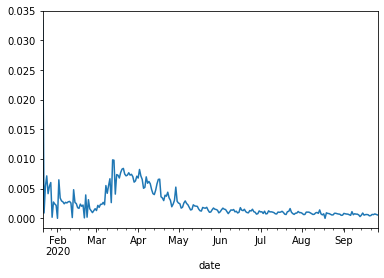

In [24]:
# Create plots

df.death_rate.plot()

<AxesSubplot:xlabel='date'>

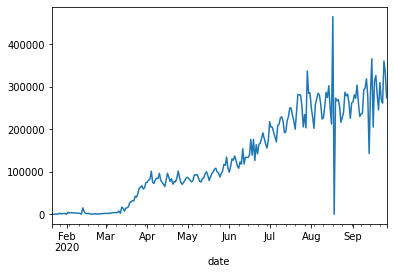

In [25]:
# Boxplots und ausreißer bereinigen über Filter

df.new_cases.plot()

<AxesSubplot:>

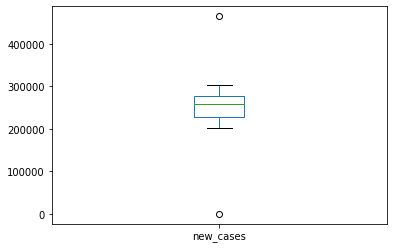

In [26]:
# Auffälligkeit im August untersuchen...
df[df.index.month==8].new_cases.plot(kind="box")

In [27]:
# Es gibt scheinbar zwei Ausreißer...
df[(df.new_cases < 10) | (df.new_cases > 400000)].head(5)

,deaths,cases,active,new_cases,new_deaths,death_rate,bad_day
date,,,,,,,
2020-02-01,259,12049,11507,1,0,0.000000,0
2020-08-17,1553894,43960620,14438087,464697,10998,0.000762,1
2020-08-18,780384,22107978,7229407,0,0,0.000000,0


In [28]:
# Offenbar liegt hier ein Fehler vor, wir eliminieren die beiden Zeilen...
df = df[df.index!="2020-08-17"]
df = df[df.index!="2020-08-18"]

<AxesSubplot:title={'center':'Neuinfektionen der letzten 14 Tage'}, xlabel='date'>

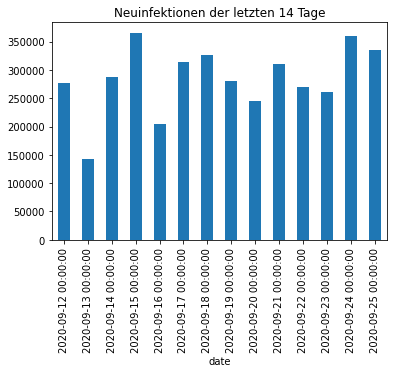

In [29]:
# Neue Cases der letzten 14 Tage

df[-15:-1].new_cases.plot(kind="bar", title="Neuinfektionen der letzten 14 Tage")  

<AxesSubplot:ylabel='Frequency'>

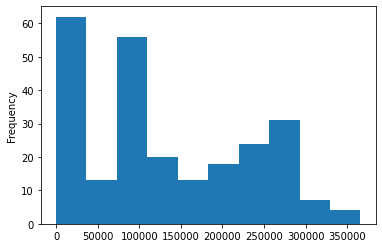

In [30]:
# Histogramm der neuen Fälle

df.new_cases.plot(kind="hist") 

<AxesSubplot:ylabel='Frequency'>

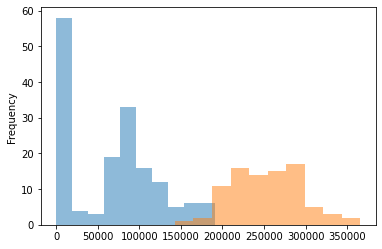

In [31]:
# Vergleich der neuen Fälle vor/nach Juli mit Histogrammen

df.loc[df.index < "2020-07-01", "new_cases"].plot(kind="hist", alpha=0.5) 
df.loc[df.index >= "2020-07-01", "new_cases"].plot(kind="hist", alpha=0.5) 

---
## 3. Zusammenhänge untersuchen und visualisieren <a id="kapitel3"/>

Im ersten Beispieldatensatz sind vermutlich wenige Zusammenhänge zu interessant, allenfalls zwischen new_deaths und new_cases. Wir verwenden das umfassendere Visualisierungspaket Seaborn, um komplexe Grafiken mit einfachen Befehlen zu erzeugen.

In [32]:
# Korrelationsmatrix
df.corr()

,deaths,cases,active,new_cases,new_deaths,death_rate,bad_day
deaths,1.000000,0.973346,0.998333,0.958066,0.616237,-0.537731,0.334048
cases,0.973346,1.000000,0.978216,0.924108,0.521991,-0.478088,0.389913
active,0.998333,0.978216,1.000000,0.964296,0.620609,-0.524397,0.337513
new_cases,0.958066,0.924108,0.964296,1.000000,0.711858,-0.468685,0.392827
new_deaths,0.616237,0.521991,0.620609,0.711858,1.000000,-0.213254,0.199634
death_rate,-0.537731,-0.478088,-0.524397,-0.468685,-0.213254,1.000000,-0.119221
bad_day,0.334048,0.389913,0.337513,0.392827,0.199634,-0.119221,1.000000


<AxesSubplot:>

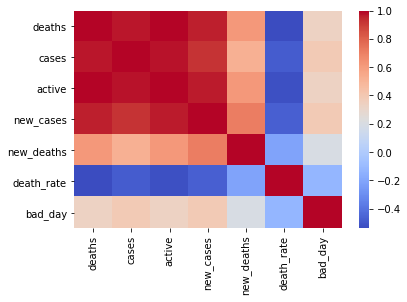

In [33]:
# Advanced Styling mit Package Seaborn, Beispiele: https://seaborn.pydata.org/tutorial/distributions.html
import seaborn as sns

sns.heatmap(df.corr(), cmap="coolwarm")

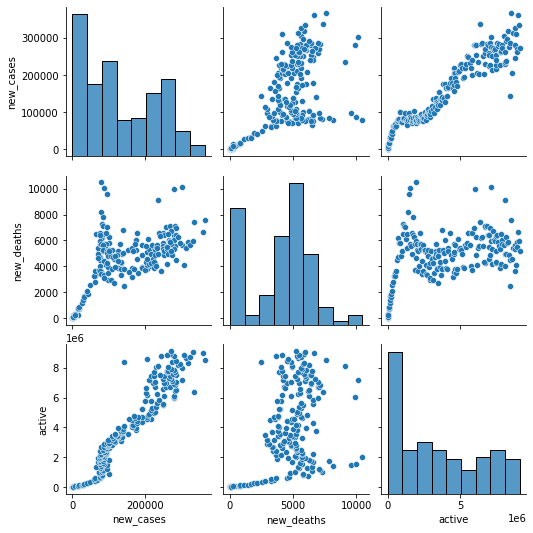

In [34]:
sns.pairplot(df.loc[:,["new_cases","new_deaths", "active"]])

---
## 4. Anwendungsbeispiel Minecraft Kernbohrung <a id="kapitel4"/>

Zunächst lesen wir die CSV-Daten ein und ergänzen mit den gelernten Werkzeugen die Blocknamen zu den Ids um.

In [35]:
df_kern = pd.read_csv("kernbohrung.csv")
df_kern.head(5)

,y,blocktyp
0,0,7
1,1,7
2,2,1
3,3,1
4,4,1


### 4.1. Datenaufbereitung
Im ersten Schritt ergänzen wir zu den Block-Ids die Blocknamen.

In [36]:
# In einem Dictionary sind die häufigsten Block-Ids den Blocknamen zugeordnet
block_names = {
    0: "Air",
    1: "Stone",
    2: "Grass",
    3: "Dirt",
    4: "Cobblestone",
    5: "Wood Planks",
    6: "Sapling",
    7: "Bedrock",
    8: "Water",
    9: "Water",
    10: "Lava",
    11: "Lava",
    12: "Sand",
    13: "Gravel",
    14: "Gold Ore",
    15: "Iron Ore",
    16: "Coal Ore",
    17: "Wood",
    18: "Leaves",
    21: "Lapislazuli Ore",
    24: "Sandstone"
}
df_kern["blockname"] = df_kern.blocktyp.replace(block_names)  # Suchen/Ersetzen anhand des Dictionary
df_kern.sample(5)

,y,blocktyp,blockname
52,52,9,Water
59,59,9,Water
34,34,1,Stone
45,45,1,Stone
20,20,1,Stone


Nun segmentieren wir die Kernbohrung nach Höhe sowohl in drei und 20 gleich große Schichten (33%-Quantile, Perzentile).  

Pandas bieten hierfür ```qcut```, die anhand eines Merkmals Quantilintervalle berechnet und diese je Zeile zurückgibt:

In [37]:
df_kern["layer"] = pd.qcut(df_kern.y, 3, labels = ["low", "mid", "high"])
df_kern["perzentil"] = pd.qcut(df_kern.y, 10, labels = range(1,11))
df_kern.sample(5)

,y,blocktyp,blockname,layer,perzentil
73,73,0,Air,high,9
68,68,0,Air,high,8
38,38,1,Stone,mid,5
23,23,1,Stone,low,3
1,1,7,Bedrock,low,1


### 4.2. Datenvisualisierung
Sehen wir uns zunächst die Anzahl der Blocktypen gesamt und in den drei wesentlichen Schichten an:

<AxesSubplot:>

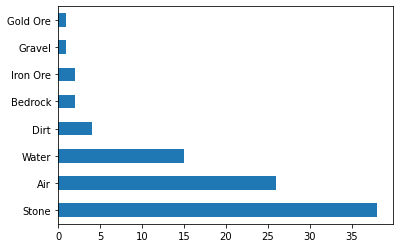

In [38]:
df_kern.blockname.value_counts().plot(kind="barh")


Sehen wir uns zunächst die Anzahl der Blocktypen gesamt und in den drei wesentlichen Schichten an:

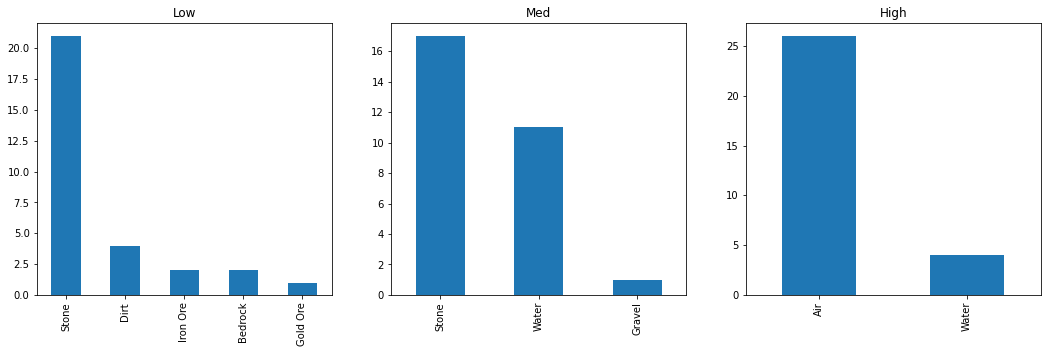

In [39]:
fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].set_title("Low")
df_kern[df_kern.layer=="low"].blockname.value_counts().plot(kind="bar", ax=ax[0])
ax[1].set_title("Med")
df_kern[df_kern.layer=="mid"].blockname.value_counts().plot(kind="bar", ax=ax[1])
ax[2].set_title("High")
df_kern[df_kern.layer=="high"].blockname.value_counts().plot(kind="bar", ax=ax[2])
plt.show()

### 4.3. Datenvisualisierung aggregierter Daten
Um in einem Beispiel alles bisher gelernte zusammen zu nehmen, betrachten wir nun die Verteilung des Blöcke "Stone", "Water", "Air", "Gold Ore" ("swag") über die Perzentile hinweg:

In [40]:
# Stone und alle anderen Blocktypen zu Stone/Other zusammenfassen
df_swag = df_kern.loc[ ~ df_kern.blockname.isin(["Gold Ore", "Water","Air"]), "blockname"] = "Stone/Other"
df_swag = df_kern.loc[:,["perzentil","blockname","blocktyp"]]
dist = df_swag.groupby(["perzentil","blockname"]).agg("count").fillna(0).unstack()
dist.columns = dist.columns.get_level_values(1)

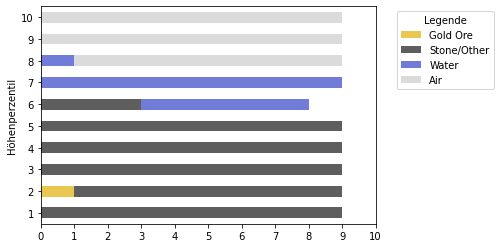

In [41]:
# Spalten sortieren
dist = dist.loc[:,["Gold Ore", "Stone/Other","Water","Air"]]

# Diagramm erzeugen
dist.plot(kind="barh", stacked=True, xticks=range(0,11),
            xlabel="Höhenperzentil", ylabel="Anzahl Blöcke",
            alpha=0.7, color=["#E2B007", "0.1", "#3444C8","0.8"])
plt.legend(title='Legende', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

---
## 5. Anwendungsbeispiel Kreditvergabe <a id="kapitel4"/>

Wir betrachten im Folgenden einen Datensatz mit Privatkreditvorgängen einer deutschen Bank.  
Hierbei durchlaufen wir dieselbe Prozedur, bauen aber die Grafiken etwas eleganter auf.

Der Datensatz kommt vom Datebankserver und umfasst folgende Merkmalen:
   >  *Age* (numeric)  
   >  *Sex* (text: male, female)  
   >  *Job* (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)  
   >  *Housing* (text: own, rent, or free)  
   >  *Saving accounts* (text - little, moderate, quite rich, rich)  
   >  *Checking account* (text - little, moderate, quite rich, rich)   
   >  *Credit amount* (numeric, in EUR)  
   >  *Duration* (numeric, in month)  
   >  *Purpose* (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others  
   >  *Risk* (Value target - Good or Bad Risk)  

### 5.1. Daten einlesen und aufbereiten

In [42]:
# Module importieren

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Visualisierung-Stil für Diagramme mit Seaview setzen
sns.set(font_scale = 1.1,               # Schriften etwas größer als normal
       palette     = "pastel",        # siehe: http://seaborn.pydata.org/tutorial/color_palettes.html
       style       = "whitegrid")       # Schriften etwas größer als normal

In [43]:
# Verbindung zum Datenbankserver herstellen

%load_ext sql
%sql sqlite:///data/smi-data.db

# SQL-Abfrage durchführen und Ergebnis in Variable result speichern        
        
result = %sql SELECT * FROM credit_ger

# Aus Result ein DataFrame machen und in Variable df speichern

df = result.DataFrame()
df = df.set_index(["id"])
df.head(5)

The sql extension is already loaded. To reload it, use:
  %reload_ext sql
 * sqlite:///data/smi-data.db
Done.


,index,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
id,,,,,,,,,,,
0,0,67,male,2,own,NA,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NA,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [44]:
# Spaltenbenennungen vereinfachen
df = df.rename({
    "Age": "age",
    "Sex": "sex",
    "Job": "job",
    "Housing": "housing",
    "Saving accounts": "savings", 
    "Checking account": "cash",
    "Credit amount": "amount",
    "Duration": "duration",
    "Purpose": "purpose",
    "Risk": "risk"
}, axis="columns")

### 5.2. Merkmale untersuchen und visualisieren

In [45]:
# Deskriptive Statistik der wichtigsten Merkmale

df[['age', 'duration', 'amount']].describe()

,age,duration,amount
count,1000.000000,1000.000000,1000.000000
mean,35.546000,20.903000,3271.258000
std,11.375469,12.058814,2822.736876
min,19.000000,4.000000,250.000000
25%,27.000000,12.000000,1365.500000
50%,33.000000,18.000000,2319.500000
75%,42.000000,24.000000,3972.250000
max,75.000000,72.000000,18424.000000


#### Untersuchung Kreditausfälle und Alter

In [46]:
# Globale Kreditausfallquote

# Berechnung mit DataFrame-Filtern

credit_default_rate = df[df.risk=="good"].risk.count() / df.risk.count()
print (credit_default_rate)

0.7


In [47]:
# Alternative Berechnung mit Kreuztabelle

pd.crosstab(df.risk, columns="count", normalize="columns")      # normalize: keine abs. Häufigkeit, sondern relative Häufigkeit in Spalten angeben

col_0,count
risk,
bad,0.3
good,0.7


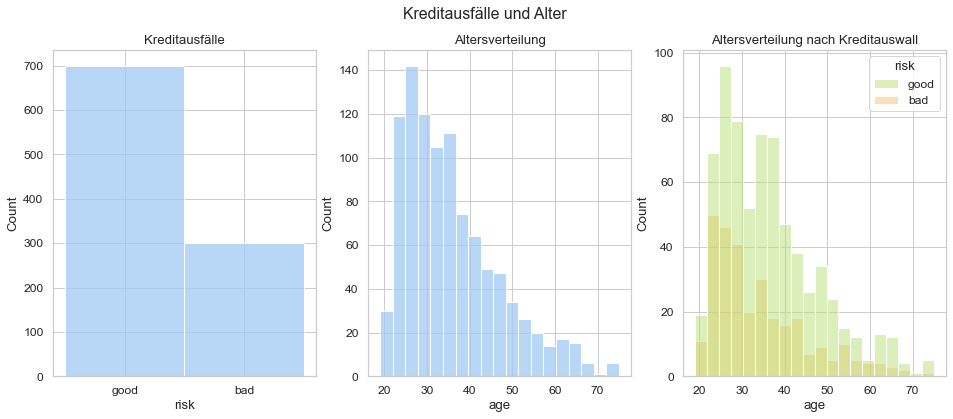

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(16,6))
fig.suptitle("Kreditausfälle und Alter")

ax[0].set_title("Kreditausfälle")
sns.histplot(df.risk, ax=ax[0])

ax[1].set_title("Altersverteilung")
sns.histplot(df.age, ax=ax[1])

ax[2].set_title("Altersverteilung nach Kreditauswall")
sns.histplot(x=df.age, hue=df.risk, ax=ax[2], palette="RdYlGn_r", bins=20)

plt.show()

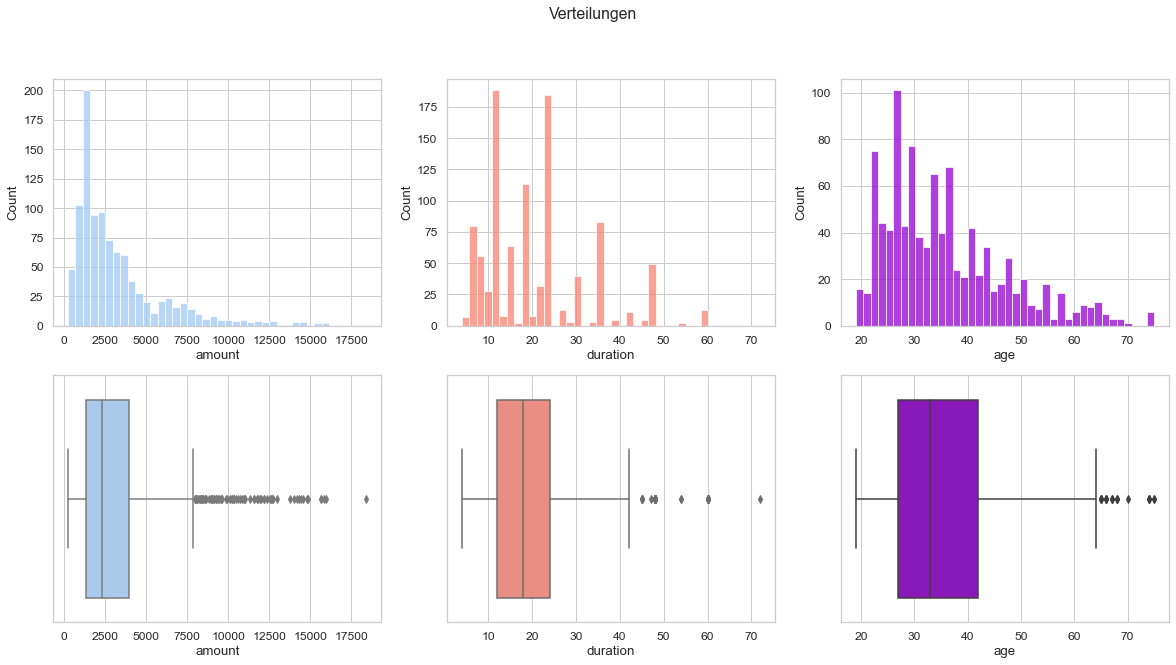

In [49]:
fig, ax = plt.subplots(2,3,figsize=(20,10))
plt.suptitle("Verteilungen")
sns.histplot(df.amount, bins=40, ax=ax[0,0]);
sns.histplot(df.duration, bins=40, ax=ax[0,1], color="salmon");
sns.histplot(df.age, bins=40, ax=ax[0,2], color="darkviolet");

sns.boxplot(x=df.amount, ax=ax[1,0]);
sns.boxplot(x=df.duration, ax=ax[1,1], color="salmon");
sns.boxplot(x=df.age, ax=ax[1,2], color="darkviolet");

plt.show() 

#### Auffälligkeiten
- Kredite typischerweise 1400-4000 EUR und 1-2 Jahre
- Kredite mit vielen Ausreißerun nach oben (>7500)
- Kreditnehmer Ende 20 bis Anfang 40 

### 5.3. Zusammenhänge untersuchen und visualisieren

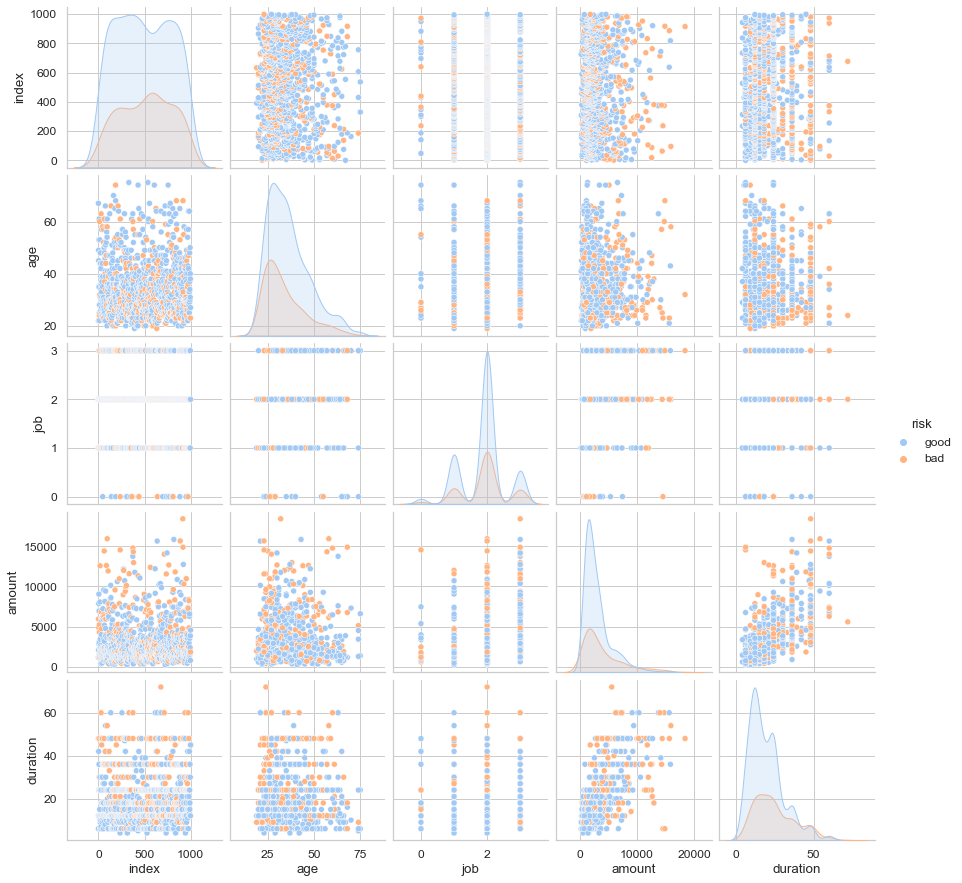

In [50]:
# Bestehen Zusammenhänge zwischen den kardinalen und/oder metrischen Merkmalen?

sns.pairplot(df, hue="risk")

#### Auffälligkeiten
- Amount vs. Duration: Größere Kredite werden in überwiegender Zahl für längere Laufzeiten vergeben.

In [51]:
# Zweck des Kredits vs. Rückzahlungshäufigkeit

pd.crosstab(df.purpose, df.risk, normalize="index")        # normalize: keine absolute Häufigkeit sondern zeilenweise (index) relative Häufigkeit angeben

risk,bad,good
purpose,,
business,0.350515,0.649485
car,0.314540,0.685460
domestic appliances,0.333333,0.666667
education,0.389831,0.610169
furniture/equipment,0.320442,0.679558
radio/TV,0.221429,0.778571
repairs,0.363636,0.636364
vacation/others,0.416667,0.583333


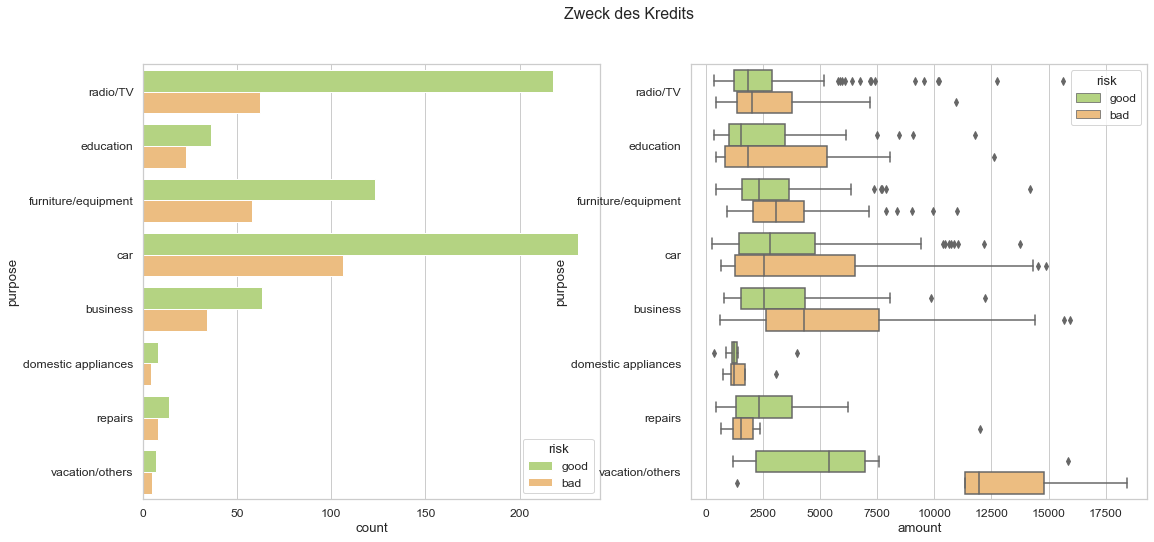

In [52]:
# Rückzahlungsquoten scheinen bei 60-70% zu liegen
# Genauere Untersuchung durch Visualisierung
fig, ax = plt.subplots(1,2,figsize=(18,8))
plt.suptitle('Zweck des Kredits')

sns.countplot(y=df.purpose, hue=df.risk, ax=ax[0], palette="RdYlGn_r")
sns.boxplot(y=df.purpose, x=df.amount, hue=df.risk, ax=ax[1], palette="RdYlGn_r")

plt.show()

#### Auffälligkeiten
- Hoher Zusammenhang zwischen Ausfallrisko und Kreditzweck
- Übermäßig teure Reisekredite (>11k) fallen alle aus
- Höhere Kredite fallen eher aus

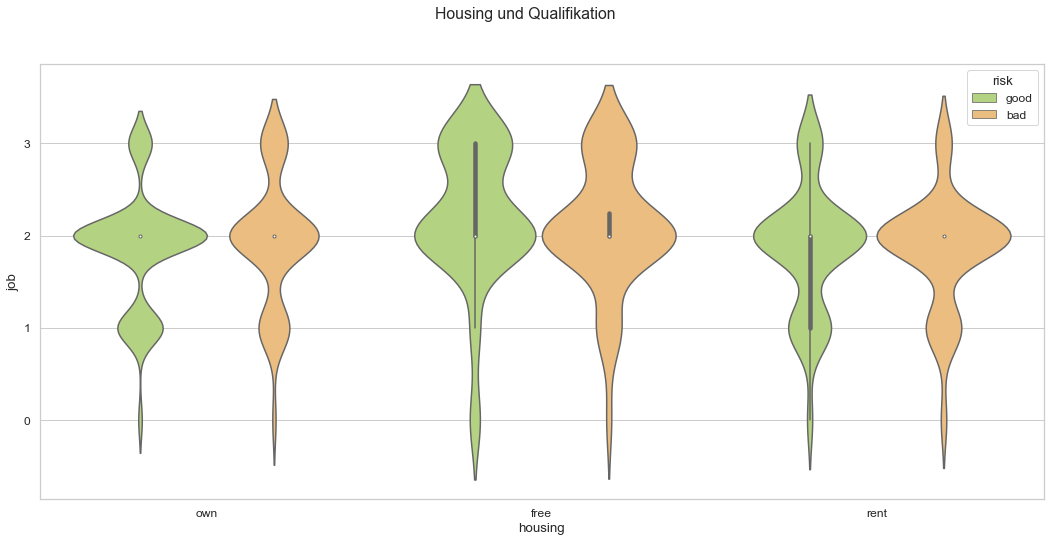

In [53]:
# Zweck des Kredits vs. Wohnsituation und Qualifikation

fig, ax = plt.subplots(1,1,figsize=(18,8))
plt.suptitle('Housing und Qualifikation')

sns.violinplot(x=df.housing, y=df.job, hue=df.risk, palette="RdYlGn_r");

#### Auffälligkeiten
- Geringe Qualifikation, kein Wohneigentum oder Mietverhältnis ist eine problematische Kombination
- Bei Wohneigentum generell höhere Rückzahlungshäufigkeit, insbl. mit Berufsausbildung ("skilled", job = 2)
- In höchster Qualifikationsstufe keine Wechselwirkung mit Wohnsituation erkennbar

---
### <span style="color:#FF5D02;">Aufgabe: Exploration weiterer Merkmale</span>
Untersuche die Merkmale ```sex```, ```savings``` und ```cash``` einzeln und im Zusammenhang mit der Kreditrückzahlungsquote!  

Führe die Untersuchung sowohl tabellarisch als auch grafisch durch.